In [5]:
import torch
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
import pandas as pd
import json
import plotly.express as px
from tabulate import tabulate

In [6]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Get Data and Model

In [8]:
class SmokingDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            stop, start, step = key.indices(len(self))

            length = len(range(stop, start, step))
            X = torch.zeros([length, 300])
            y = torch.zeros([length, 1])

            for j,i in enumerate(range(stop, start, step)):
                xi, yi = self[i]
                X[j] = xi
                y[j] = yi

            return (X, y)

        elif isinstance(key, int):
            X, y = torch.load(os.path.join(self.dir, f'{key}.pt'))
            return (X.flatten(), y)

In [9]:
test_dataset = SmokingDataset('pipeline/4_all/test/')
test_length = len(test_dataset)

test_dataloader = DataLoader(test_dataset, batch_size=10000)
n_test_batch = len(test_dataloader)

In [11]:
n_hl = 10

# Define Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
model.load_state_dict(torch.load('model/poster-model.pt'))
    
criterion = nn.BCEWithLogitsLoss()

# Test on Validation Set

100%|██████████| 37/37 [01:03<00:00,  1.72s/it]


Accuracy: 96.85%
Loss: 0.088558


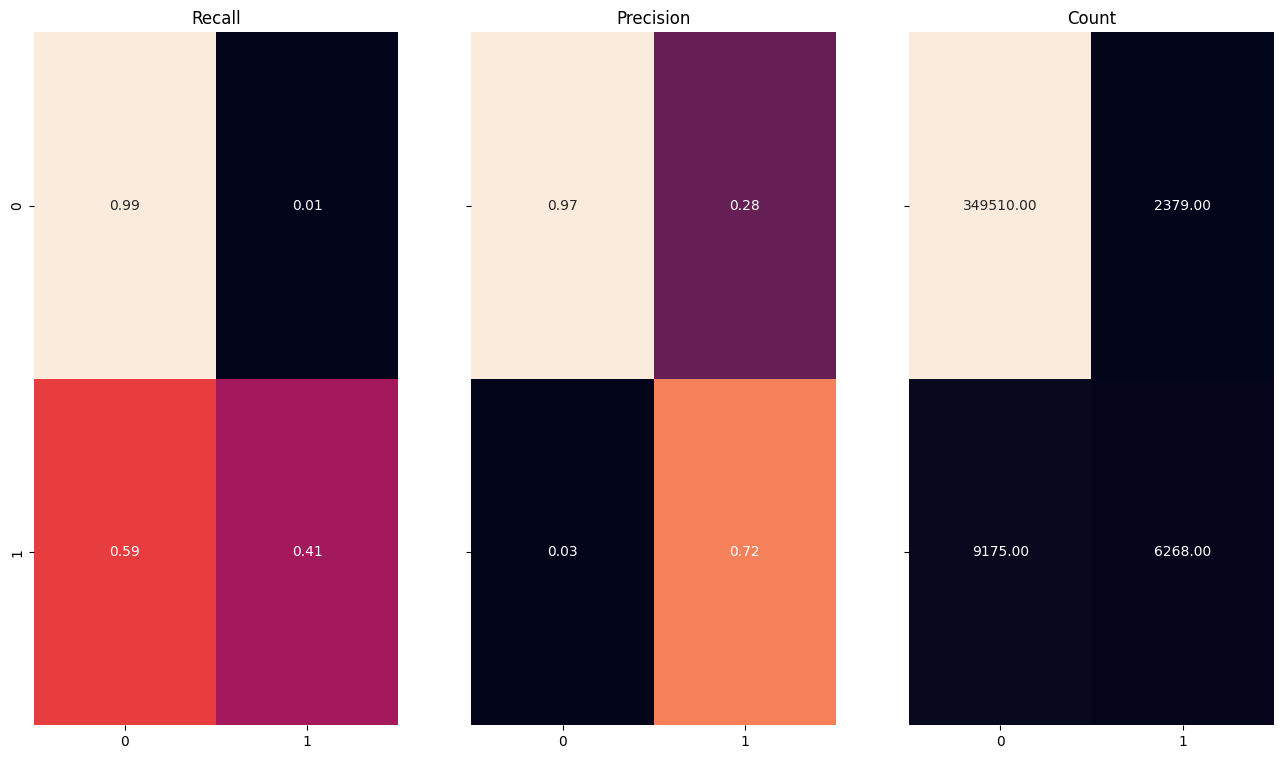

In [12]:
os.system('mkdir -p results/evaluation/test')

# Test on test dataset
model.eval()

preds = []
n_correct = 0
loss = 0
i = 0
for X_test, y_test in tqdm(test_dataloader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    logits = model(X_test)
    pred = torch.round(nn.Sigmoid()(logits))

    n_correct += sum(y_test == pred)
    preds += pred.flatten().tolist()
    loss += criterion(logits, y_test).item()
    i+=1

y_pred = np.array(preds).reshape(-1,1)
accuracy = (n_correct / test_length).item()
loss = loss / len(test_dataloader)
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.5}')


# Confusion Matrix

y_true = test_dataset[:][1]

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
fig.set_size_inches(16, 9)
plt.savefig(f'results/evaluation/test/test-cm.jpg',dpi=400,bbox_inches='tight')

# Test on holdout sets (continous)

25
Accuracy: 97.45%
Loss: 0.1388
35


mkdir: cannot create directory ‘results/evaluation/holdouts/35’: File exists


Accuracy: 98.59%
Loss: 0.03405
36


mkdir: cannot create directory ‘results/evaluation/holdouts/36’: File exists


Accuracy: 98.76%
Loss: 0.03881
31


mkdir: cannot create directory ‘results/evaluation/holdouts/31’: File exists


Accuracy: 95.62%
Loss: 0.2098


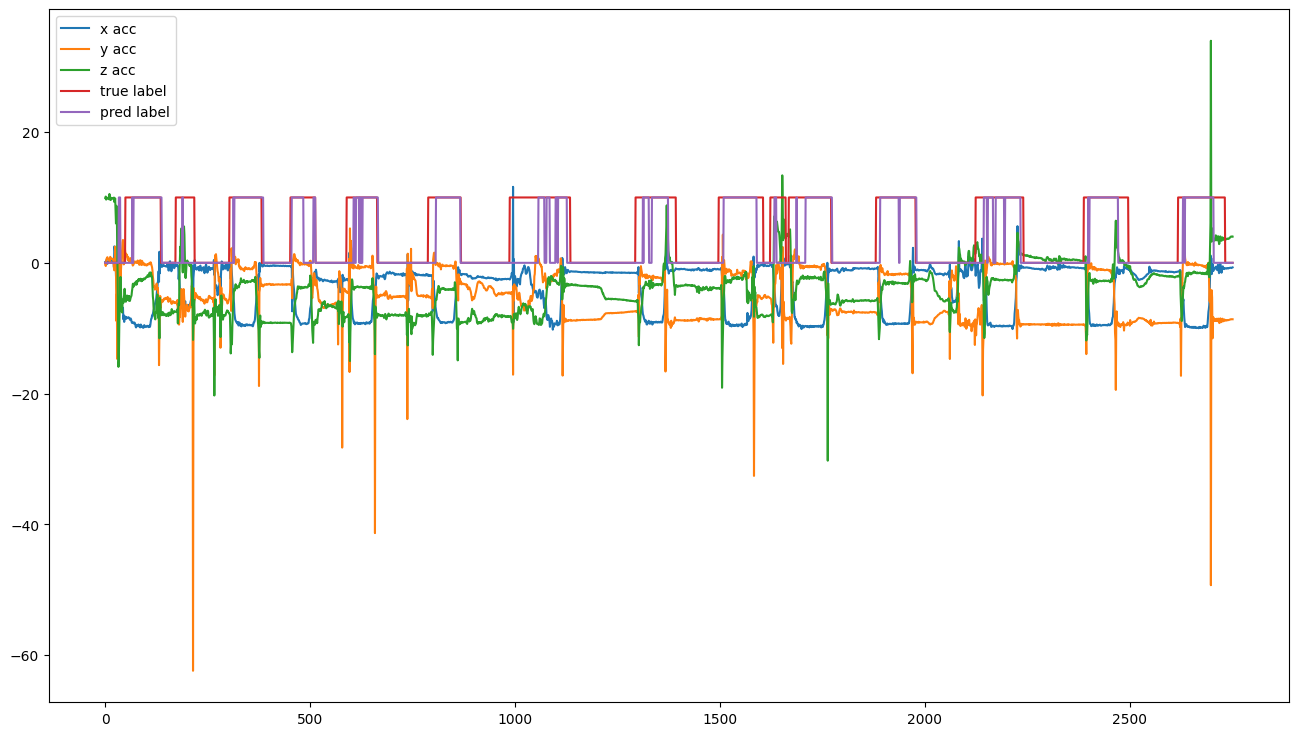

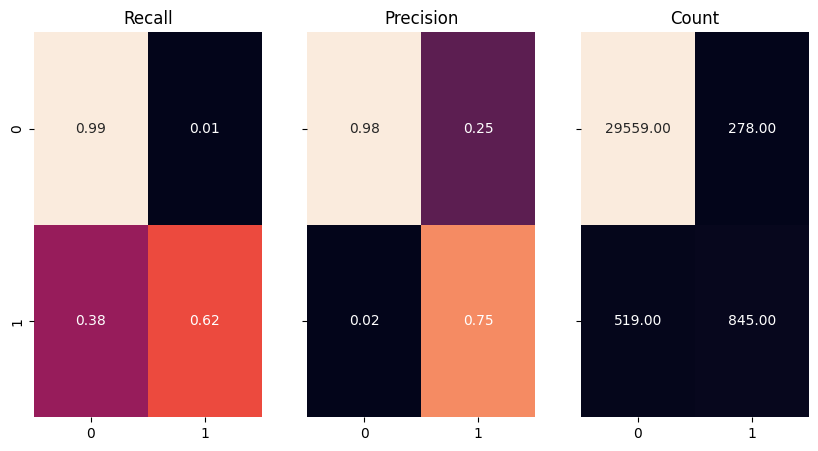

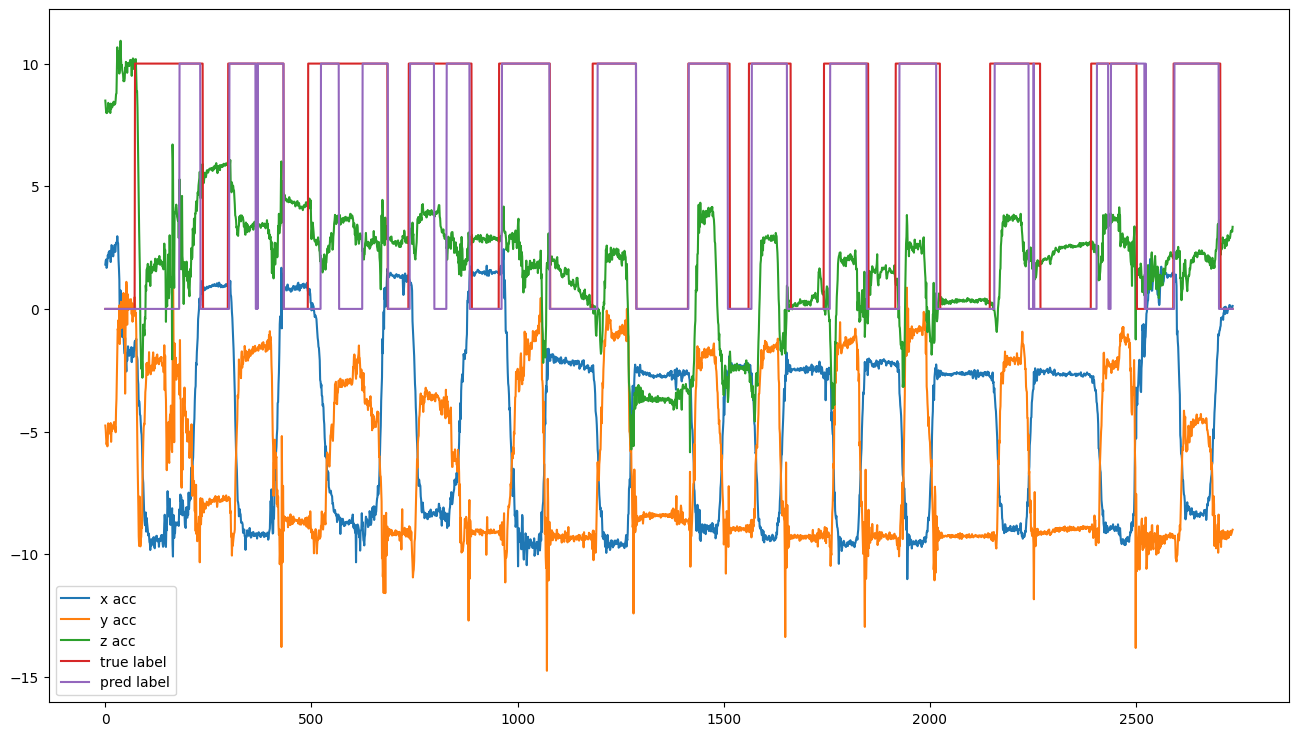

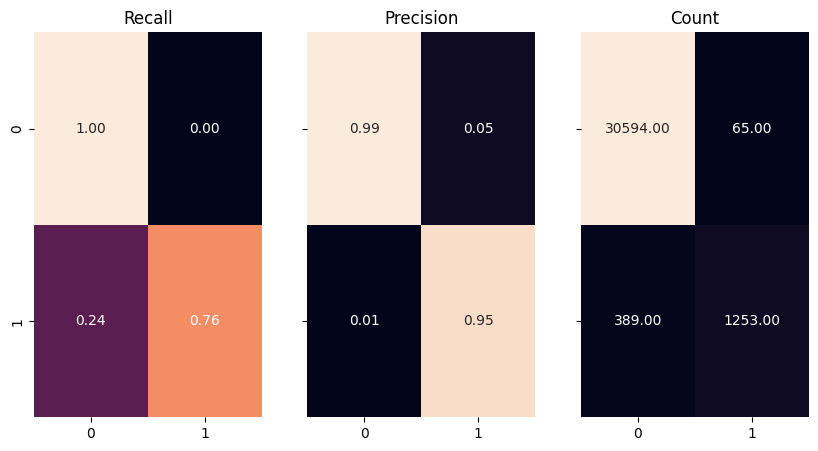

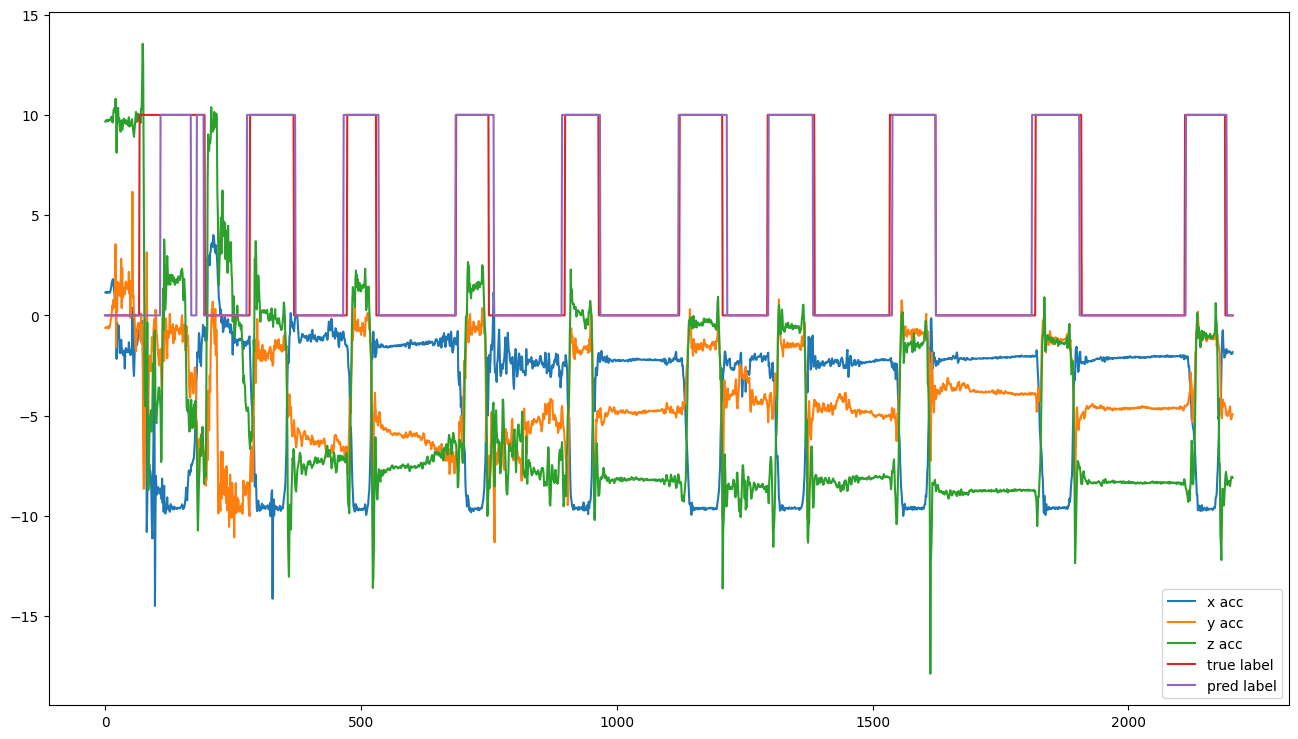

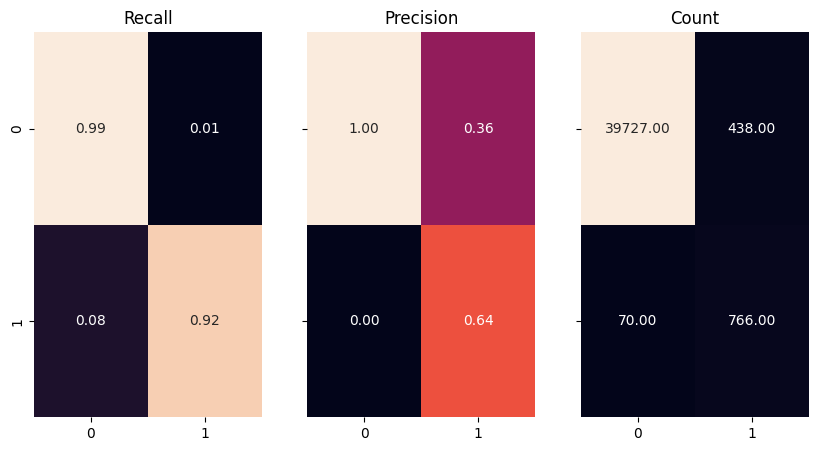

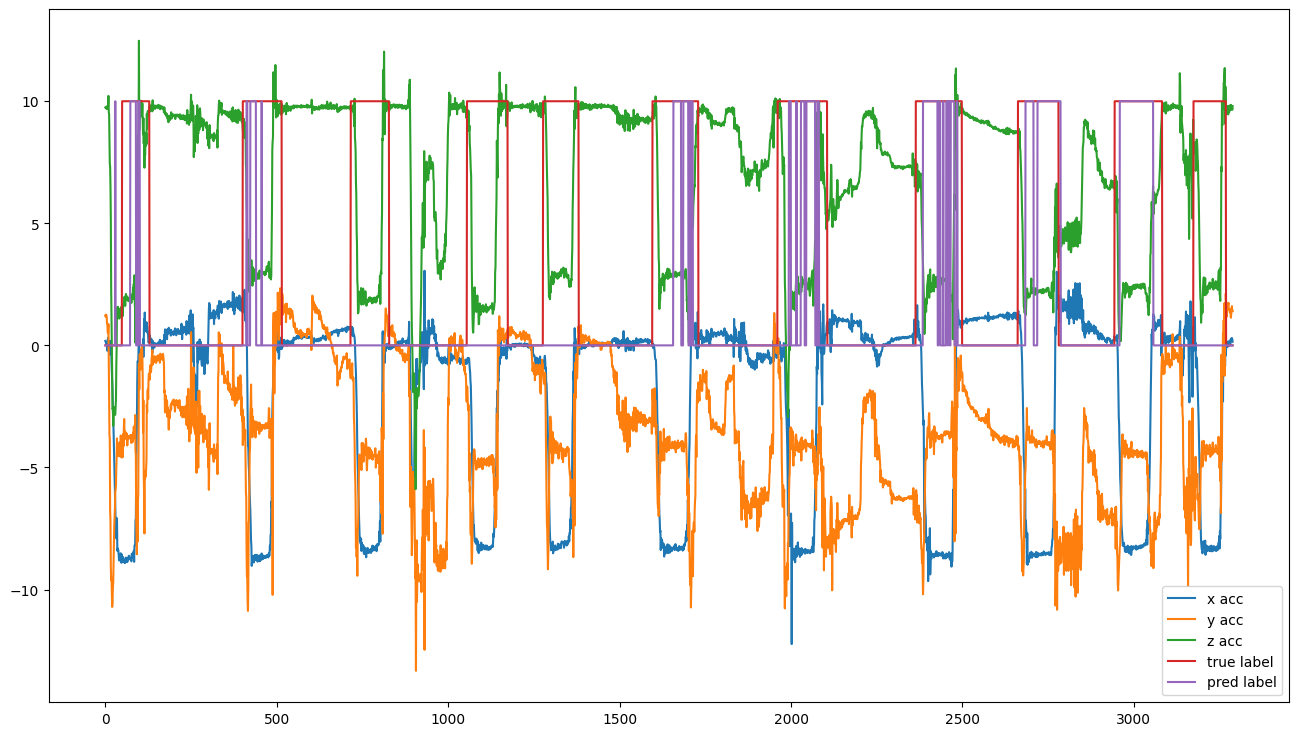

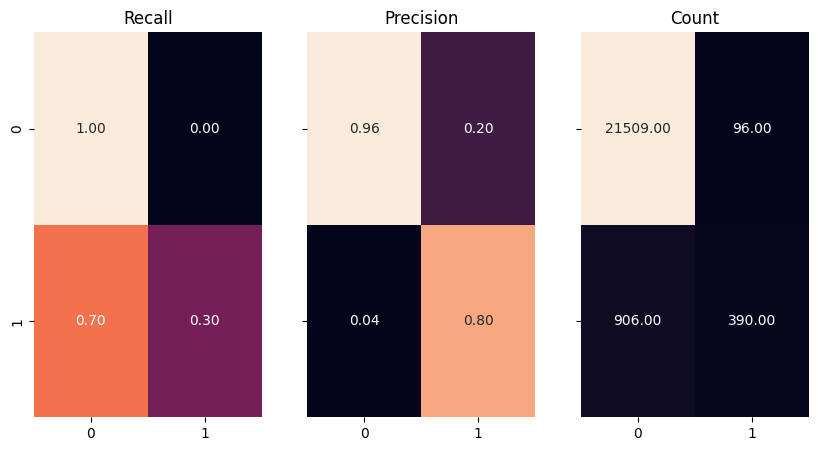

In [13]:
os.system('mkdir -p results/evaluation/holdouts')
step = 10000

model.eval()
for file in os.listdir('pipeline/holdouts/'):
    index = file.split('-')[0]
    print(index)
    os.system(f'mkdir results/evaluation/holdouts/{index}')
    preds = []
    n_correct = 0
    loss = 0

    # Read in holdout session
    dataset = torch.load(f'pipeline/holdouts/{file}')
    session_length = len(dataset)
    dataloader = DataLoader(dataset, batch_size=step)
    y_true = dataset[:][1]

    df = pd.read_csv(f'pipeline/1_dm/{index}.csv')
    df['y_true'] = np.pad(y_true.flatten()*10, (49, 50), mode='constant', constant_values=0)

    for X, y in dataloader:
        X = X.to(device) 
        y = y.to(device)

        logits = model(X)
        pred = torch.round(nn.Sigmoid()(logits))

        n_correct += sum(y == pred)
        preds += pred.flatten().tolist()
        loss += criterion(logits, y).item()

    y_pred = np.array(preds).reshape(-1,1)
    accuracy = (n_correct / session_length).item()
    loss = loss/len(dataloader)
    print(f'Accuracy: {100*accuracy:.4}%')
    print(f'Loss: {loss:.4}')

    df['y_pred'] = np.pad(y_pred.flatten()*10, (49, 50), mode='constant', constant_values=0)

    # Save Predictions
    np.save(f'results/evaluation/holdouts/{index}/y_pred.npy', y_pred)
    np.save(f'results/evaluation/holdouts/{index}/y_true.npy', y_true)

    # Save Values
    pd.DataFrame({'Accuracy': [accuracy], 'Loss': [loss]}).to_csv(f'results/evaluation/holdouts/{index}/holdout-{index}-metrics.csv')

    # Save Figures
    start = 0
    stop = 0
    with open(f'data/{index}/{index}_data.json', 'r') as f:
        annot = json.load(f)
        start = annot['start'] // 5
        stop = annot['end'] // 5

    df_plot = df.iloc[start:stop].reset_index(drop=True)
    df_plot.columns = ['x acc', 'y acc', 'z acc', 'true label', 'pred label']
    fig, ax = plt.subplots(1, figsize=(16,9))
    ax.plot(df_plot, label=df_plot.columns)
    ax.legend()
    plt.savefig(f'results/evaluation/holdouts/{index}/holdout-{index}.jpg', dpi=400)

    # Confusion Matrix
    fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
    axes[0].set_title('Recall')
    axes[1].set_title('Precision')
    axes[2].set_title('Count')
    plt.savefig(f'results/evaluation/holdouts/{index}/holdout-{index}-cm.jpg', dpi=400, bbox_inches='tight')

In [16]:
# plotly
holdout = 31

y_true = np.load(f'results/evaluation/holdouts/{holdout}/y_true.npy')
y_pred = np.load(f'results/evaluation/holdouts/{holdout}/y_pred.npy')

df = pd.read_csv(f'pipeline/1_dm/{holdout}.csv')
df['y_true'] = np.pad(y_true.flatten()*10, (49, 50), mode='constant', constant_values=0)
df['y_pred'] = np.pad(y_pred.flatten()*10, (49, 50), mode='constant', constant_values=0)

figure = px.line(df)
figure.show(renderer='browser')

Opening in existing browser session.


Gtk-Message: 16:44:24.410: Failed to load module "xapp-gtk3-module"
Gtk-Message: 16:44:24.410: Failed to load module "appmenu-gtk-module"


## Evaluate Predictions
- Total number of puffs
- Average puff duration
- Total puff duration

In [15]:
for holdout in os.listdir('results/evaluation/holdouts/'):
    y_pred = np.load(f'results/evaluation/holdouts/{holdout}/y_pred.npy')
    y_true = np.load(f'results/evaluation/holdouts/{holdout}/y_true.npy')

    last_pred = 0
    pred_puffs = []

    last_true = 0
    true_puffs = []

    for yp, yt in zip(y_pred, y_true):
        # y_pred
        if yp:
            if last_pred:
                # continue puff
                pred_puffs[-1] += 1
            else:
                # new puff
                pred_puffs.append(1)
        last_pred = yp

        # y_true
        if yt:
            if last_true:
                # continue puff
                true_puffs[-1] += 1
            else:
                # new puff
                true_puffs.append(1)
        last_true = yt


    n_true_puffs = len(true_puffs)
    n_pred_puffs = len(pred_puffs)

    print(f'\nHoldout Set {holdout}')
    print(tabulate(
        [['True', n_true_puffs, np.mean(true_puffs), sum(true_puffs)],
         ['Pred', n_pred_puffs, np.mean(pred_puffs), sum(pred_puffs)]
        ], 
        headers=['Total Number of Puffs', 'Average Puff Duration', 'Total Puffs Length'],
        tablefmt="simple_grid"
    ))


Holdout Set 35
┌──────┬─────────────────────────┬─────────────────────────┬──────────────────────┐
│      │   Total Number of Puffs │   Average Puff Duration │   Total Puffs Length │
├──────┼─────────────────────────┼─────────────────────────┼──────────────────────┤
│ True │                      13 │                126.308  │                 1642 │
├──────┼─────────────────────────┼─────────────────────────┼──────────────────────┤
│ Pred │                      29 │                 45.4483 │                 1318 │
└──────┴─────────────────────────┴─────────────────────────┴──────────────────────┘

Holdout Set 31
┌──────┬─────────────────────────┬─────────────────────────┬──────────────────────┐
│      │   Total Number of Puffs │   Average Puff Duration │   Total Puffs Length │
├──────┼─────────────────────────┼─────────────────────────┼──────────────────────┤
│ True │                      11 │                 117.818 │                 1296 │
├──────┼─────────────────────────┼──────────